In [69]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.fft import fft, ifft, ifftshift, fftshift
import scipy
from scipy.stats import norm
import pandas as pd
import time
import py_vollib.black_scholes_merton as bsm

In [50]:
def payoff(x, xi, alpha, K, L, U, C, theta):
    # x = real space grid
    # xi = fourier space grid
    # alpha = dampening factor, + for call, - for put
    # L = lower trunc limit for option
    # U = upper trunc limit for option
    # C = stock price
    # theta = +1 call, -1 put

    # Scale
    S = C * np.exp(x)

    # Payoff - formula 1 above
    g = np.exp(alpha * x) * np.maximum(theta * (S - K), 0) * (S >= L) * (S <= U)

    # Analytical Fourier transform of the payoff
    l = np.log(L / C)  # lower log barrier
    k = np.log(K / C)  # log strike
    u = np.log(U / C)  # upper log barrier

    # Integration bounds
    if theta == 1:  # call
        a = max(l, k)
        b = u
    else:  # put
        a = min(k, u)
        b = l

    xi2 = alpha + 1j * xi
    # Formula 2
    G = C * ((np.exp(b * (1 + xi2)) - np.exp(a * (1 + xi2))) / (1 + xi2)
            - (np.exp(k + b * xi2) - np.exp(k + a * xi2)) / xi2)

    # Eliminable discontinuities for xi = 0, otherwise 0/0 = NaN
    if alpha == 0:
        G[len(x) // 2] = C * (np.exp(b) - np.exp(a) - np.exp(k) * (b - a))
    elif alpha == -1:
        G[len(x) // 2] = C * (b - a + np.exp(k - b) - np.exp(k - a))

    # Plot to compare the analytical and numerical payoffs
    gn = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(G))) / ((x[1] - x[0]) * len(x))

    plt.plot(x, g, 'g:', x, np.real(gn), 'r:')
    plt.xlabel('x')
    plt.ylabel('g')
    if theta == 1:
        plt.title('Damped payoff function for a call option')
    else:  # put
        plt.title('Damped payoff function for a put option')
    plt.legend(['analytical', 'numerical'])
    plt.show()

    # return stock * exp(grid space), damped option payoff, FT of payoff
    return S, g, G

In [51]:
def figures_ft(S, x, xi, f, Psi, g, G):
    """
    Plots various aspects of the Fourier transform process in financial modeling.

    Args:
    S (array): Underlying asset prices.
    x (array): Grid in real space.
    xi (array): Grid in Fourier space.
    f (array): Probability density function in real space.
    Psi (array): Characteristic function in Fourier space.
    g (array): Payoff function in real space.
    G (array): Fourier transform of the payoff function.
    """

    # Plotting the characteristic function at time T
    plt.figure()
    plt.plot(xi, Psi.real, 'r', xi, Psi.imag, 'g')
    plt.xlabel('xi')
    plt.ylabel('Psi(xi,T)')
    plt.legend(['Re Psi(xi,T)', 'Im Psi(xi,T)'])
    plt.title('Characteristic function at time T')

    # Plotting the probability density function at time T
    plt.figure()
    plt.plot(x, f.real, 'r', x, f.imag, 'g')
    plt.xlabel('x')
    plt.ylabel('f(x,T)')
    plt.title('Probability density function at time T')

    # Comparison of the numerical and analytical Fourier transforms of the payoff

    # Normal space
    gn = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(G))) / ((x[1] - x[0]) * len(x))

    # Plotting the payoff function in real space
    plt.figure()
    plt.plot(x, g, 'r', x, gn.real, 'g')
    plt.xlabel('x')
    plt.ylabel('Re g')
    plt.legend(['analytical', 'numerical'])
    plt.title('Payoff function')

    plt.figure()
    plt.plot(x, np.zeros_like(x), 'ro', x, gn.imag, 'gs')
    plt.xlabel('x')
    plt.ylabel('Im g')
    plt.legend(['analytical', 'numerical'])
    plt.title('Payoff function')

    plt.figure()
    plt.plot(x, g / gn.real, 'gs')
    plt.xlabel('x')
    plt.ylabel('g_a/Re g_n')
    plt.xlim([0, S[-1]])  # Assuming S is sorted and has the upper limit
    plt.title('Payoff function')

    plt.figure()
    plt.plot(x, g, 'r', S, gn.real, ':r', x, gn.imag, ':g')
    plt.xlabel('x')
    plt.ylabel('g')
    plt.legend(['g_a', 'Re g_n', 'Im g_n'])
    plt.title('Payoff function')

    # Reciprocal space
    Gn = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(g))) * (x[1] - x[0]) * len(x)

    # Plotting the Fourier transform of the payoff function in reciprocal space
    plt.figure()
    plt.plot(xi, G.real, 'ro', xi, Gn.real, 'gs')
    plt.xlabel('xi')
    plt.ylabel('Re G')
    plt.legend(['analytical', 'numerical'])
    plt.title('Fourier transform of the payoff function')

    plt.figure()
    plt.plot(xi, G.imag, 'ro', xi, Gn.imag, 'gs')
    plt.xlabel('xi')
    plt.ylabel('Im G')
    plt.legend(['analytical', 'numerical'])
    plt.title('Fourier transform of the payoff function')

    plt.figure()
    plt.plot(xi, G.real / Gn.real, 'ro', xi, G.imag / Gn.imag, 'gs')
    plt.xlabel('xi')
    plt.legend(['Re(G_a)/Re(G_n)', 'Im(G_a)/Im(G_n)'])
    plt.title('Fourier transform of the payoff function')

    plt.figure()
    plt.plot(xi, G.real, 'r', xi, Gn.real, ':r', xi, G.imag, 'g', xi, Gn.imag, ':g')
    plt.xlabel('xi')
    plt.ylabel('G')
    plt.legend(['Re G_a', 'Re G_n', 'Im G_a', 'Im G_n'])
    plt.title('Fourier transform of the payoff function')

    plt.show()

In [52]:
def charfunction(xi, parameters, flag=0):
    if 'flag' not in locals():
        flag = 0

    meancorrection = (parameters['rf'] - parameters['q']) * parameters['dt'] - np.log(charfunction0(-1j, parameters))
    F = np.exp(1j * meancorrection * xi) * charfunction0(xi, parameters)
    
    if flag == 0:
        F = np.conj(F)

    return F

def charfunction0(xi, parameters):
    distr = parameters['distr']

    if distr == 1:  # Normal
        m = parameters['m']
        s = parameters['s']
        F = np.exp(1j * xi * m - 0.5 * (s * xi) ** 2)

    elif distr == 2:  # Normal inverse Gaussian (NIG)
        alpha = parameters['alpha']
        beta = parameters['beta']
        delta = parameters['delta']
        F = np.exp(-delta * (np.sqrt(alpha ** 2 - (beta + 1j * xi) ** 2) - np.sqrt(alpha ** 2 - beta ** 2)))

    elif distr == 3:  # Variance Gamma (VG)
        theta = parameters['theta']
        s = parameters['s']
        nu = parameters['nu']
        F = (1 - 1j * xi * theta * nu + 0.5 * nu * (s * xi) ** 2) ** (-1 / nu)

    elif distr == 4:  # Meixner
        alpha = parameters['alpha']
        beta = parameters['beta']
        delta = parameters['delta']
        F = (np.cos(beta / 2) / np.cosh((alpha * xi - 1j * beta) / 2)) ** (2 * delta)

    elif distr == 5:  # Carr, Geman, Madan and Yor (CGMY)
        C = parameters['C']
        G = parameters['G']
        M = parameters['M']
        Y = parameters['Y']
        F = np.exp(C * np.gamma(-Y) * ((M - 1j * xi) ** Y - M ** Y + (G + 1j * xi) ** Y - G ** Y))

    elif distr == 6:  # Kou double exponential jump-diffusion
        s = parameters['s']
        lambd = parameters['lambda']
        pigr = parameters['pigr']
        eta1 = parameters['eta1']
        eta2 = parameters['eta2']
        F = np.exp(-0.5 * (s * xi) ** 2 + lambd * ((1 - pigr) * eta2 / (eta2 + 1j * xi) + pigr * eta1 / (eta1 - 1j * xi) - 1))

    elif distr == 7:  # Merton jump-diffusion
        s = parameters['s']
        alpha = parameters['alpha']
        lambd = parameters['lambda']
        delta = parameters['delta']
        F = np.exp(-0.5 * (s * xi) ** 2 + lambd * (np.exp(1j * xi * alpha - 0.5 * (delta * xi) ** 2) - 1))

    elif distr == 8:  # Levy alpha-stable
        alpha = parameters['alpha']
        beta = parameters['beta']
        gamm = parameters['gamm']
        m = parameters['m']
        c = parameters['c']
        F = np.exp(1j * xi * m - c * np.abs(gamm * xi) ** alpha * (1 - 1j * beta * np.sign(xi) * np.tan(alpha / 2 * np.pi)))

    else:
        F = None

    return F


In [53]:
def kernel(ngrid, xmin, xmax, parameters, alpha=0, disc=1, flag=0):
    if flag == 0:
        disc = 1  # default for backward characteristic function

    N = ngrid // 2
    dx = (xmax - xmin) / ngrid
    x = dx * np.arange(-N, N)
    dxi = 2 * np.pi / (xmax - xmin)
    xi = dxi * np.arange(-N, N)

    H = charfunction(xi + 1j * alpha, parameters, flag)  # characteristic function

    if disc == 1:
        H = H * np.exp(-parameters['rf'] * parameters['dt'])  # discount

    h = np.real(fftshift(fft(ifftshift(H)))) / (xmax - xmin)  # discounted kernel

    return x, h, xi, H

# Include the charfunction function here

# Example usage: #
# parameters = {'rf': 0.05, 'dt': 0.1}
# x, h, xi, H = kernel(256, -5, 5, parameters, alpha=0, disc=1, flag=0)

In [54]:
def set_parameters(distr, T, dt, rf, q=None):
    parameters = {'distr': distr, 'T': T, 'dt': dt, 'rf': rf}

    if q is not None:
        parameters['q'] = q
    else:
        parameters['q'] = 0

    if distr == 1:  # Normal
        m = 0  # mean
        s = 0.4  # standard deviation

        parameters['m'] = m
        parameters['s'] = s * np.sqrt(dt)
        parameters['lambdam'] = 0
        parameters['lambdap'] = 0

    elif distr == 2:  # NIG
        alpha = 15
        beta = -5
        delta = 0.5

        parameters['alpha'] = alpha
        parameters['beta'] = beta
        parameters['delta'] = delta * dt
        parameters['lambdam'] = beta - alpha
        parameters['lambdap'] = beta + alpha
        parameters['FLc'] = delta
        parameters['FLnu'] = 1

    elif distr == 3:  # VG
        C = 4
        G = 12
        M = 18

        nu = 1 / C
        theta = (1 / M - 1 / G) * C
        s = np.sqrt(2 * C / (M * G))

        parameters['nu'] = nu / dt
        parameters['theta'] = theta * dt
        parameters['s'] = s * np.sqrt(dt)
        parameters['lambdam'] = -M
        parameters['lambdap'] = G

    elif distr == 4:  # Meixner
        alpha = 0.3977
        beta = -1.4940
        delta = 0.3462

        parameters['alpha'] = alpha
        parameters['beta'] = beta
        parameters['delta'] = delta * dt

    elif distr == 5:  # CGMY
        C = 4
        G = 50
        M = 60
        Y = 0.7

        parameters['C'] = C * dt
        parameters['G'] = G
        parameters['M'] = M
        parameters['Y'] = Y
        parameters['lambdam'] = -M
        parameters['lambdap'] = G
        parameters['FLc'] = 2 * C * np.abs(np.gamma(-Y) * np.cos(np.pi * Y / 2))
        parameters['FLnu'] = Y

    elif distr == 6:  # Kou double exponential
        s = 0.1
        lambda_val = 3
        pigr = 0.3
        eta1 = 40
        eta2 = 12

        parameters['s'] = s * np.sqrt(dt)
        parameters['lambda'] = lambda_val * dt
        parameters['pigr'] = pigr
        parameters['eta1'] = eta1
        parameters['eta2'] = eta2
        parameters['lambdam'] = -eta1
        parameters['lambdap'] = eta2
        parameters['FLc'] = s ** 2 / 2
        parameters['FLnu'] = 2

    elif distr == 7:  # Merton jump-diffusion
        s = 0.4
        alpha = 0.1
        lambda_val = 0.5
        delta = 0.15

        parameters['s'] = s * np.sqrt(dt)
        parameters['alpha'] = alpha
        parameters['lambda'] = lambda_val * dt
        parameters['delta'] = delta

    elif distr == 8:  # Stable
        alpha = 2
        beta = 0
        gamm = 0.3 / np.sqrt(2)
        m = 0
        c = 1 / np.sqrt(1 + (beta * np.tan(alpha / 2 * np.pi)) ** 2)

        parameters['alpha'] = alpha
        parameters['beta'] = beta
        parameters['gamm'] = gamm * dt
        parameters['m'] = m
        parameters['c'] = c

    return parameters

# Example usage:
# parameters_dict = set_parameters(1, 1, 0.1, 0.05)
# print(parameters_dict)


## START OF CODE

In [55]:
from Kernal import Kernal
from Payoff.ipynb import Payoff
from figures_ft import figures_ft

In [56]:
# Define parameters and time grid
npaths = 20000 # number of paths
T = 1 # time horizon
nsteps = 200 # number of time steps
dt = T/nsteps # time step
t = np.linspace(0,T,nsteps+1) # observation times

muS = 0.05 
r = muS
q = 0.02
sigma = 0.4 # model parameters of the diffusion part (GBM)
muJ = -0.1
sigmaJ = 0.15
lamb = 0.5 # model parameters of the jump part (NCPP)
S0 = 1 # initial stock price
K = 1.10

In [57]:
# Monte Carlo
# Compute the increments of the GBM
dW = (muS-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(nsteps,npaths)
# ABM - dW = mu*dt + sigma*np.sqrt(dt)*np.random.randn(nsteps,npaths)

# Compute the increments of the NCPP
dN = np.random.poisson(lamb*dt,(nsteps,npaths))
dJ = muJ*dN + sigmaJ*np.sqrt(dN)*np.random.randn(nsteps,npaths)

# Sum the increments of the ABM and the NCPP
dX = dW + dJ

# Accumulate the increments
X = np.vstack([np.zeros((1,npaths)),np.cumsum(dX,axis=0)])

Text(0.5, 0, 'x')

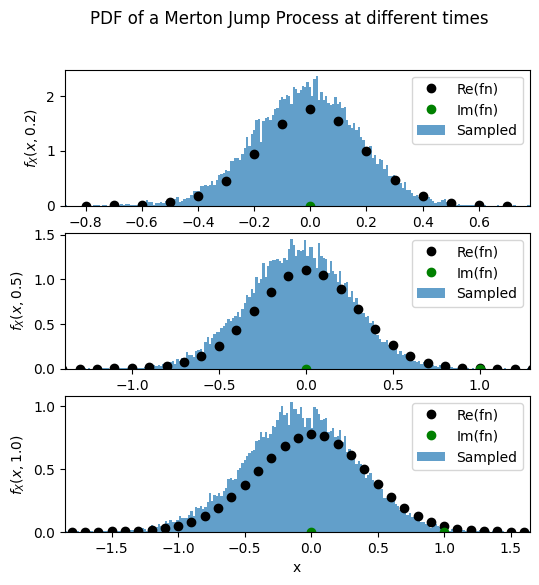

In [58]:
# FT Approx of Pdf using IFFT
N = 512
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)

# GRID IN FOURIER SPACE (Pulsation)
dxi = (2*np.pi)/(N*dx) #Grid step size in fourier space
upperx = N*dxi # Upper truncation limit in fourier space
xi = dxi * np.arange(-N/2, N/2)  # grid in Fourier space

fig, ax = plt.subplots(3,1, figsize=(6,6))
for i,time in enumerate([40,100,-1]):
    ax[i].hist(X[time,:],density=True,bins=nsteps, alpha=0.7)

    # Pulsation space: 
    char_func = np.exp(1j * muS * xi * t[time] - 0.5 * sigma**2 * xi**2 * t[time] + lamb * (np.exp(1j * xi * muJ - 0.5 * sigmaJ**2 * xi**2) - 1) * t[time])
    f_X = fftshift(fft(ifftshift(char_func))) / upperx
    ax[i].plot(x,np.real(f_X), 'ko', np.imag(f_X), 'go')

    ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
    ax[i].legend(['Re(fn)', 'Im(fn)','Sampled'])
    ax[i].set_xlim(min(X[time,:]), max(X[time,:]))

plt.suptitle('PDF of a Merton Jump Process at different times')
plt.xlabel('x')

## 1. Analytical

In [59]:
muABM = r-q-0.5*sigma**2 # drift coefficient of the arithmetic Brownian motion
d2 = (np.log(S0/K)+muABM*T)/(sigma*np.sqrt(T))
d1 = d2 + sigma*np.sqrt(T)
Vca = S0*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
Vpa = K*np.exp(-r*T)*norm.cdf(-d2) - S0*np.exp(-q*T)*norm.cdf(-d1)
# Put-call parity: Vp + S0exp(-q*T) = Vc + Kexp(-rT) 

data = {'': ['Own analytical BS:'],
    'call': [Vca],
    'put': [Vpa],
    } #'Python analytical BS:', call_price, put_price
df = pd.DataFrame(data)
print(df.to_string(index=False, float_format='%.6f'))

                       call      put
Own analytical BS: 0.129654 0.195808


## 2. Fourier Transform

/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_93514/2367696296.py:31: RuntimeWarning: invalid value encountered in divide
  G = C * ((np.exp(b * (1 + xi2)) - np.exp(a * (1 + xi2))) / (1 + xi2)


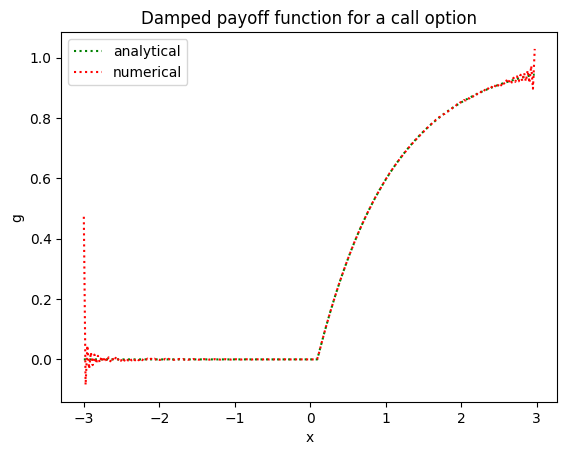

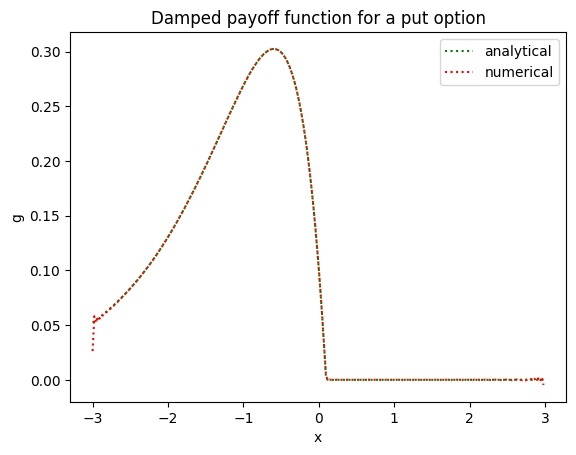

Call Price: 0.1202 
Put price: 0.2178


In [64]:
# Fourier Transform Method Parameters
xwidth = 6  # Width of the support in real space (log price domain)
ngrid = 2 ** 8  # Number of grid points in the Fourier transform
alpha = -1  # Damping factor for the Fourier transform in call option pricing

# Grids in Real and Fourier Space
N = ngrid // 2
b = xwidth / 2
dx = xwidth / ngrid  # Grid spacing in real space
x = dx * np.arange(-N, N)  # Real space grid (log price domain)
dxi = 2*np.pi / xwidth  # (or np.pi/b) Grid spacing in Fourier space
xi = dxi * np.arange(-N, N)  # Fourier space grid

# Characteristic Function for Call and Put Options
# These functions are used in Fourier transform method for option pricing
# muABM = (muS-0.5*sigma**2)
# muRN = r - q - 0.5*sigma**2 # drift under RN measure
muGBM = (r - q - 0.5 * sigma**2 - lamb*(np.exp(muJ + 0.5*sigma**2)-1))

xiac = xi + 1j * alpha  # Shift for call option characteristic function
# GBM + Merton;
char_func_c = lamb * (np.exp(1j * xiac * muJ - 0.5 * sigmaJ**2 * xiac**2) - 1)
psic = 1j * muGBM * xiac - 0.5 * (sigma * xiac) ** 2 + char_func_c
Psic = np.exp(psic * T)  # Characteristic function for call option

xiap = xi - 1j * alpha  # Shift for put option characteristic function
char_func_p = lamb * (np.exp(1j * xiap * muJ - 0.5 * sigmaJ**2 * xiap**2) - 1)
psip = 1j * muGBM * xiap - 0.5 * (sigma * xiap) ** 2 + char_func_p
Psip = np.exp(psip * T)  # Characteristic function for put option

# Fourier Transform of Payoff
U = S0 * np.exp(b)  # Upper barrier for payoff
L = S0 * np.exp(-b)  # Lower barrier for payoff
S, gc, Gc = payoff(x=x, xi=xi, alpha= alpha, K=K, L=L, U=U,C=S0, theta=1)  # Call payoff computation
S, gp, Gp = payoff(x=x, xi=xi, alpha= -alpha, K=K, L=L, U=U,C= S0, theta=-1)  # Put payoff computation

c = (np.exp(-r * T) * np.real(fftshift(fft(ifftshift(Gc * np.conj(Psic))))) / xwidth)  # Call option pricing via FFT
#R instead of muS

# Similar computation is done for the put option price using corresponding variables
p = (np.exp(-r * T) * np.real(fftshift(fft(ifftshift(Gp * np.conj(Psip))))) / xwidth)  # Put option pricing via FFT

VcF = np.interp(S0, S, c)  # Interpolating call option price at current spot price
VpF = np.interp(S0, S, p)  # Interpolating put option price at current spot price
print('Call Price:',round(VcF,4),'\nPut price:', round(VpF,4))

/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_93514/1014795045.py:83: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xi, G.real / Gn.real, 'ro', xi, G.imag / Gn.imag, 'gs')
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_93514/1014795045.py:83: RuntimeWarning: invalid value encountered in divide
  plt.plot(xi, G.real / Gn.real, 'ro', xi, G.imag / Gn.imag, 'gs')


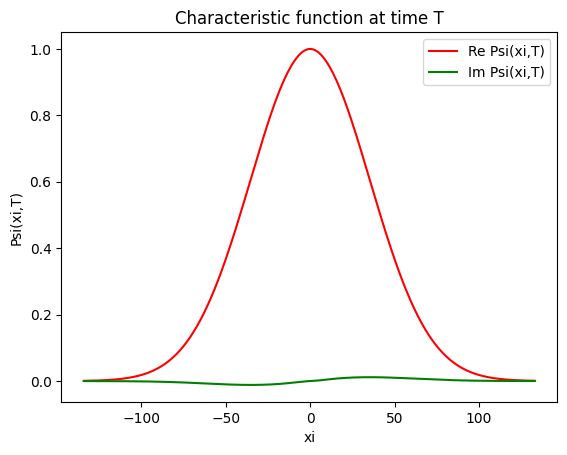

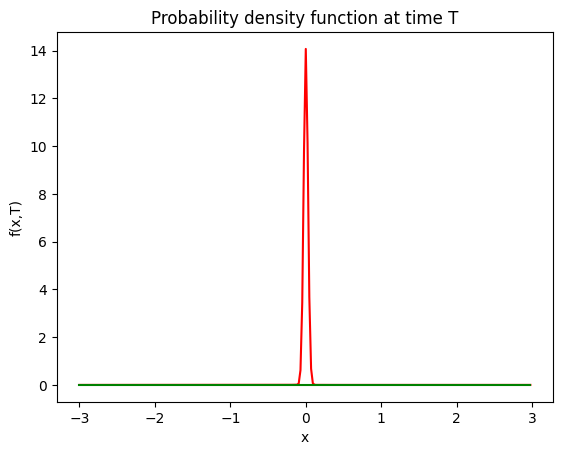

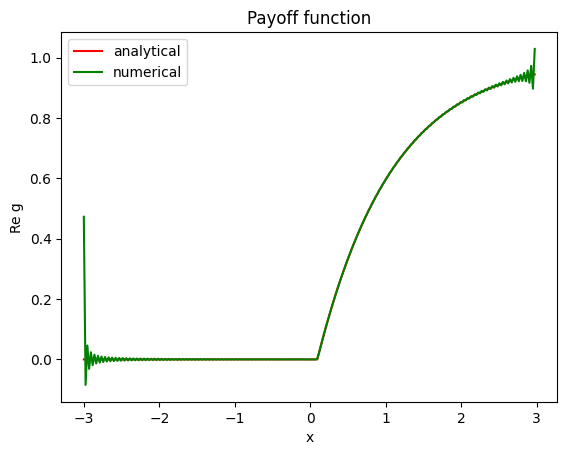

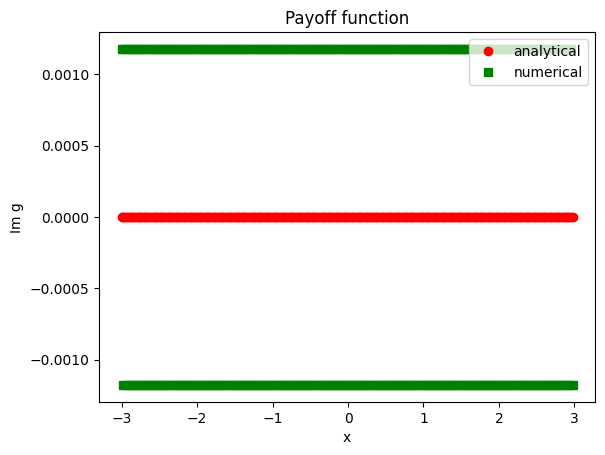

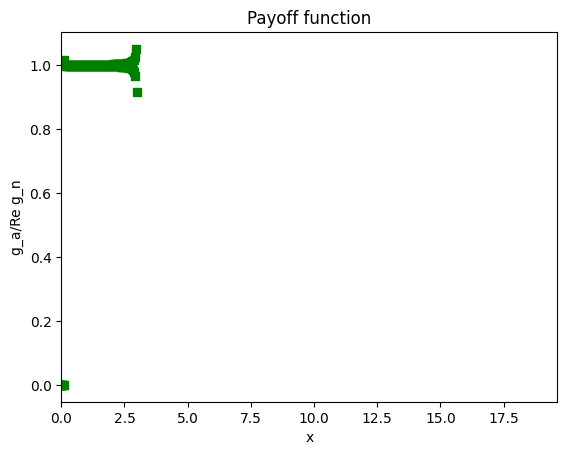

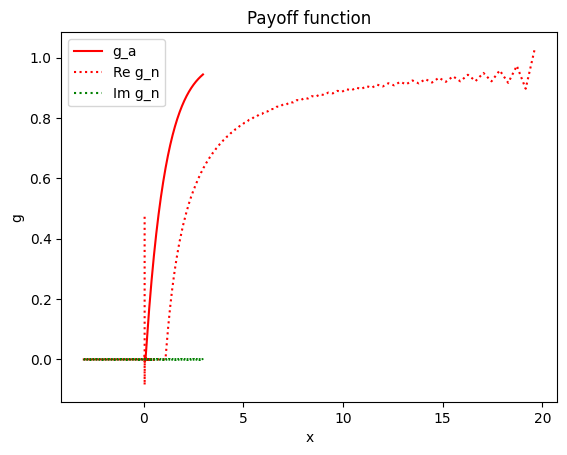

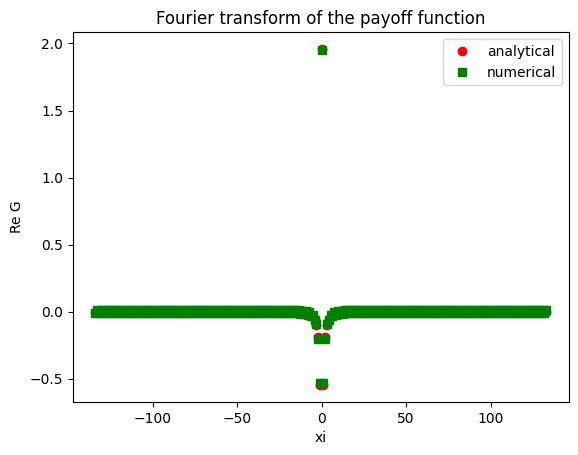

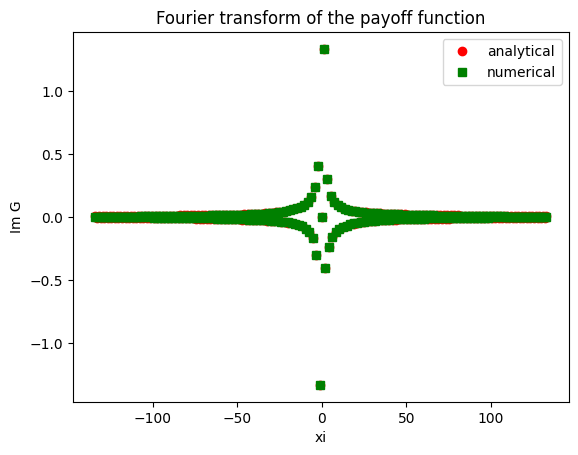

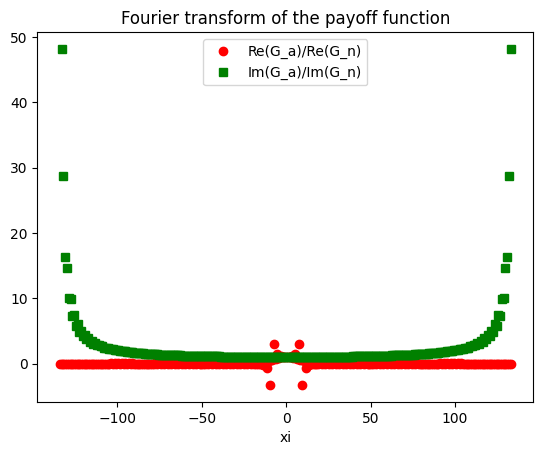

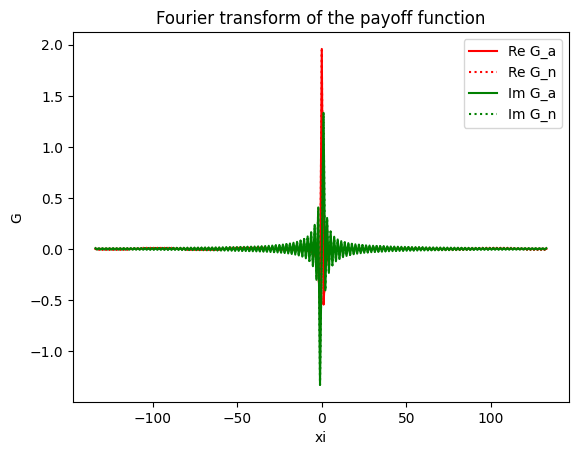

In [61]:
param_obj = set_parameters(distr=7, T=T, dt=dt, rf=r, q=q) # as above
xmin, xmax = -3, 3  # as above
x, h, xi, H = kernel(ngrid=ngrid, xmin=xmin, xmax=xmax, parameters=param_obj)
char_func = charfunction(xi, param_obj)

figures_ft(S, x, xi, h, H, gc, Gc)

## Monte Carlo

In [62]:
import time
start = time.time()
VcMCb = np.zeros(npaths)
VpMCb = np.zeros(npaths)

for i in range(npaths):
    # Arithmetic Brownian motion X(T) = log(S(T)/S(0)) at time T
    dW = muGBM*T + sigma*np.random.randn(nsteps)*np.sqrt(T)

    # Jump component
    dP = np.random.poisson(lamb*T,nsteps)
    jump = muJ * dP + sigmaJ * np.sqrt(dP) * np.random.randn(nsteps)
    
    # Combine Arithmetic Brownian motion and Jump component
    X = jump + dW

    # % Transform to geometric Brownian motion S(T) at time T
    S = S0*np.exp(X)

    # % Discounted expected payoff
    VcMCb[i] = np.exp(-r*T)*np.mean(np.maximum(S-K,0))
    VpMCb[i] = np.exp(-r*T)*np.mean(np.maximum(K-S,0))

VcMC = np.mean(VcMCb)
VpMC = np.mean(VpMCb)
scMC = np.sqrt(np.var(VcMCb)/npaths)
spMC = np.sqrt(np.var(VpMCb)/npaths)
cputime_MC = time.time()

data = {'Monte Carlo':[VcMC,VpMC,round(cputime_MC,4)],
        'Monte Carlo stdev':[scMC,spMC, 'N/A']}
df = pd.DataFrame(data)
df.index = ['Call', 'Put', 'Time']
df


,Monte Carlo,Monte Carlo stdev
Call,1.201313e-01,0.000132
Put,2.176694e-01,0.000109
Time,1.701779e+09,N/A


## Complex Congurate of the price

In [65]:
# RERUN FOURIER TAB FIRST
start_time = time.time()

c = (np.exp(-r * T) * np.real(fftshift(fft(ifftshift(np.conj(Gc) * Psic)))) / xwidth)  # Call option pricing via FFT
p = (np.exp(-r * T) * np.real(fftshift(fft(ifftshift(np.conj(Gp) * Psip)))) / xwidth) 

VcF = np.interp(S0, S, c)  # Interpolating call option price at current spot price
VpF = np.interp(S0, S, p)  # Interpolating put option price at current spot price

# Output results
cputime_T = time.time() - start_time
print('\nComplex Cong')
print(f'Call Price: {VcF:.4f}, Put Price: {VpF:.4f}, Run Time: {cputime_T:.4f}')


Complex Cong
Call Price: 0.1202, Put Price: 0.2178, Run Time: 0.0009


## Trapz Integration Rule

In [66]:
from scipy.integrate import trapz

# Start timing
start_time = time.time()

# Call and Put prices using trapz integration
VcT = np.real(trapz(np.exp(-r * T) * Gc * np.conj(Psic) / xwidth))
VpT = np.real(trapz(np.exp(-r * T) * Gp * np.conj(Psip) / xwidth))

# Output results
cputime_T = time.time() - start_time
print('\nFourier Trapz Method')
print(f'Call Price: {VcT:.4f}, Put Price: {VpT:.4f}, CPU Time: {cputime_T:.4f}')


Fourier Trapz Method
Call Price: 0.1202, Put Price: 0.2178, CPU Time: 0.0004


## Sum Method

In [ ]:
# Assuming Gc, Gp, Psic, Psip, r, T, xwidth are defined

# Start timing
start_time = time.time()

# Calculate the discounted expected payoff
VcS = np.real(np.sum(np.exp(-r * T) * Gc * np.conj(Psic) / xwidth))
VpS = np.real(np.sum(np.exp(-r * T) * Gp * np.conj(Psip) / xwidth))

# Stop timing
cputime_S = time.time() - start_time


print('\nFourier Sum')
print(f'Call Price: {VcS:.4f}, Put Price: {VpS:.4f}, CPU Time: {cputime_S:.4f}')



Fourier Sum
Call Price: 0.1202, Put Price: 0.2178, CPU Time: 0.0002
